In [1]:
%reload_ext autotime
import pandas as pd
import requests
import geopandas as gpd
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map
import time
import os
from glob import glob
from coastsat import SDS_transects
import json
import matplotlib.pyplot as plt

In [2]:
poly = gpd.read_file("polygons.geojson")
poly = poly[poly.id.str.startswith("nzd")]
poly.set_index("id", inplace=True)
poly

area id_sorted      northing  \
id                                              
nzd0001  3.069093e+06   nzd0001 -4.085604e+06   
nzd0002  1.507931e+06   nzd0002 -4.086100e+06   
nzd0003  2.484730e+06   nzd0003 -4.087232e+06   
nzd0006  9.619509e+05   nzd0004 -4.090732e+06   
nzd0007  3.109433e+06   nzd0005 -4.095516e+06   
...               ...       ...           ...   
nzd0313  2.291974e+07   nzd0558 -4.939929e+06   
nzd0314  3.124363e+07   nzd0559 -4.943102e+06   
nzd0561  8.710035e+05   nzd0560 -5.905869e+06   
nzd0562           NaN      None           NaN   
nzd0563           NaN      None           NaN   

                                                  geometry  
id                                                          
nzd0001  POLYGON ((172.96406 -34.43054, 172.99324 -34.4...  
nzd0002  POLYGON ((172.93456 -34.42857, 172.95856 -34.4...  
nzd0003  POLYGON ((173.0098 -34.42055, 173.00088 -34.44...  
nzd0006  POLYGON ((173.00532 -34.46694, 173.00612 -34.4...  
nzd0007  POLYGON ((172.99847 -34.48102, 173.00081 -34.5...  
...                                                    ...  
nzd0313  POLYGON ((172.89281 -40.50518, 172.73306 -40.5...  
nzd0314  POLYGON ((173.04122 -40.54521, 172.89309 -40.5...  
nzd0561  POLYGON ((168.53017 -46.77383, 168.52 -46.7786...  
nzd0562  POLYGON ((174.90844 -36.8799, 174.90844 -36.86...  
nzd0563  POLYGON ((176.9378 -39.33472, 176.93374 -39.33...  

[562 rows x 4 columns]

1999-08-17 22:10:00+00:00 POINT (172.97690966086745 -34.42150701355086)


<Axes: xlabel='time'>

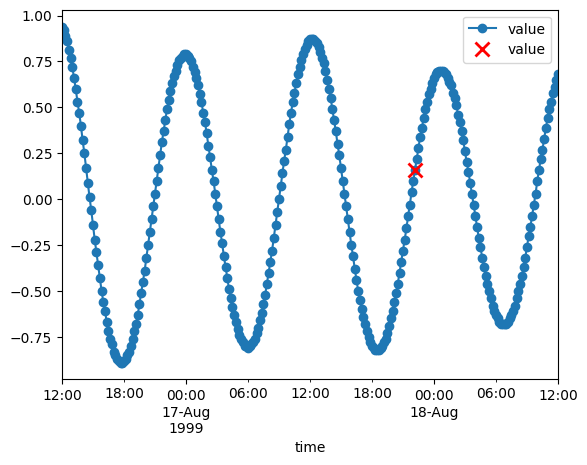

In [3]:
sitename = "nzd0001"
dates = pd.to_datetime(pd.read_csv(f"data/{sitename}/transect_time_series.csv").dates).dt.round("10min")
point = poly.geometry[sitename].centroid
datetime = dates.iloc[0]
print(datetime, point)
r = requests.get("https://api.niwa.co.nz/tides/data", params={
    "lat": point.y,
    "long": point.x,
    "numberOfDays": 2,
    "startDate": str(datetime.date()),
    "datum": "MSL",
    "interval": 10, # 10 minute resolution
    "apikey": os.environ["NIWA_API_KEY"]
}, timeout=(30,30))
df = pd.DataFrame(r.json()["values"])
df.index = pd.to_datetime(df.time)
ax = df.plot(style="o-")
df[df.index == datetime].plot(color="red", style="x", ax=ax, mew=2, ms=10)

In [4]:
datetime, datetime.tz_convert("Pacific/Auckland")

(Timestamp('1999-08-17 22:10:00+0000', tz='UTC'),
 Timestamp('1999-08-18 10:10:00+1200', tz='Pacific/Auckland'))

When I asked for 1 day (1999-08-17), I got 1999-08-16 12:00 - 1999-08-17 12:00. Have to request 2 days, then pull out the one datetime I want

In [5]:
files = pd.DataFrame({"filename": sorted(glob("data/*/transect_time_series.csv"))})
files["sitename"] = files.filename.str.split("/").str[1]
files["have_tides"] = files.sitename.apply(lambda s: os.path.isfile(f"data/{s}/tides.csv"))
files

filename sitename  have_tides
0    data/nzd0001/transect_time_series.csv  nzd0001        True
1    data/nzd0002/transect_time_series.csv  nzd0002        True
2    data/nzd0003/transect_time_series.csv  nzd0003        True
3    data/nzd0004/transect_time_series.csv  nzd0004        True
4    data/nzd0005/transect_time_series.csv  nzd0005        True
..                                     ...      ...         ...
557  data/nzd0559/transect_time_series.csv  nzd0559        True
558  data/nzd0560/transect_time_series.csv  nzd0560        True
559  data/nzd0561/transect_time_series.csv  nzd0561        True
560  data/nzd0562/transect_time_series.csv  nzd0562        True
561  data/nzd0563/transect_time_series.csv  nzd0563        True

[562 rows x 3 columns]

In [6]:
def get_tide_for_dt(point, datetime):
    while True:
        try:
            r = requests.get("https://api.niwa.co.nz/tides/data", params={
                "lat": point.y,
                "long": point.x,
                "numberOfDays": 2,
                "startDate": str(datetime.date()),
                "datum": "MSL",
                "interval": 10, # 10 minute resolution
                "apikey": os.environ["NIWA_API_KEY"]
            }, timeout=(30,30))
        except Exception as e:
            print(e)
            time.sleep(5)
            continue
        if r.status_code == 200:
            df = pd.DataFrame(r.json()["values"])
            df.index = pd.to_datetime(df.time)
            return df.value[datetime]
        elif r.status_code == 429:
            sleep_seconds = 30
            # sleep for x seconds to refresh the count
            print(f'Num of API reqs exceeded, Sleeping for: {sleep_seconds} seconds...')
            time.sleep(sleep_seconds)

for sitename in tqdm(files[~files.have_tides].sitename):
    dates = pd.to_datetime(pd.read_csv(f"data/{sitename}/transect_time_series.csv").dates).dt.round("10min")
    point = poly.geometry[sitename].centroid

    results = []
    for date in tqdm(dates):
        result = get_tide_for_dt(point, date)
        results.append({
            "dates": date,
            "tide": result
        })
    df = pd.DataFrame(results)
    df.set_index("dates", inplace=True)
    df.to_csv(f"data/{sitename}/tides.csv")

0it [00:00, ?it/s]

In [7]:
files["have_tides"] = files.sitename.apply(lambda s: os.path.isfile(f"data/{s}/tides.csv"))

In [8]:
# Transects, origin is landward. Has beach_slope
transects = gpd.read_file("transects_extended.geojson").to_crs(2193).drop_duplicates(subset="id")
transects.set_index("id", inplace=True)
transects

site_id  orientation  along_dist  along_dist_norm  beach_slope  \
id                                                                             
aus0001-0000  aus0001   104.347648    0.000000         0.000000        0.085   
aus0001-0001  aus0001    93.495734   98.408334         0.002935        0.050   
aus0001-0002  aus0001    82.069341  198.408334         0.005918        0.050   
aus0001-0003  aus0001    81.192757  298.402523         0.008900        0.055   
aus0001-0004  aus0001    81.065473  398.402523         0.011882        0.075   
...               ...          ...         ...              ...          ...   
nzd0562-0017  nzd0562          NaN         NaN              NaN        0.055   
nzd0562-0018  nzd0562          NaN         NaN              NaN        0.045   
nzd0563-0000  nzd0563          NaN         NaN              NaN        0.200   
nzd0563-0001  nzd0563          NaN         NaN              NaN        0.050   
nzd0563-0002  nzd0563          NaN         NaN              NaN        0.070   

                 cil     ciu     trend  n_points  n_points_nonan  r2_score  \
id                                                                           
aus0001-0000  0.0545  0.2000 -1.456305     654.0           342.0  0.131951   
aus0001-0001  0.0387  0.0640 -0.833581     654.0           473.0  0.052783   
aus0001-0002  0.0428  0.0647 -0.282209     654.0           491.0  0.008220   
aus0001-0003  0.0480  0.0659  0.089340     654.0           502.0  0.000987   
aus0001-0004  0.0614  0.0922  0.361437     654.0           508.0  0.017461   
...              ...     ...       ...       ...             ...       ...   
nzd0562-0017  0.0541  0.0608  0.006797     582.0           407.0  0.000019   
nzd0562-0018  0.0434  0.0461  0.284894     582.0           372.0  0.022977   
nzd0563-0000  0.1756  0.2000 -0.286535     770.0           684.0  0.020982   
nzd0563-0001  0.0323  0.1200 -0.072549     770.0           614.0  0.003174   
nzd0563-0002  0.0624  0.0742 -0.260641     770.0           632.0  0.026072   

                    mae          mse       rmse   intercept  \
id                                                            
aus0001-0000  28.721214  1321.059410  36.346381  179.407277   
aus0001-0001  26.029482  1092.336862  33.050520  210.629160   
aus0001-0002  22.896464   838.997233  28.965449  200.166307   
aus0001-0003  20.770475   691.179232  26.290288  185.295473   
aus0001-0004  19.528839   637.676213  25.252252  169.027861   
...                 ...          ...        ...         ...   
nzd0562-0017   8.181382   127.722282  11.301428  212.322965   
nzd0562-0018   9.773159   187.352460  13.687675  216.532589   
nzd0563-0000  12.984757   214.309394  14.639310  182.918496   
nzd0563-0001   8.484539    95.454639   9.770089  437.079989   
nzd0563-0002   9.013683   143.900611  11.995858  173.017496   

                                                       geometry  
id                                                               
aus0001-0000  LINESTRING (-422245.836 7118667.88, -421827.54...  
aus0001-0001  LINESTRING (-422256.313 7118525.222, -421837.6...  
aus0001-0002  LINESTRING (-422219.773 7118383.012, -421816.8...  
aus0001-0003  LINESTRING (-422187.543 7118279.615, -421786.5...  
aus0001-0004  LINESTRING (-422155.665 7118178.983, -421754.9...  
...                                                         ...  
nzd0562-0017  LINESTRING (1770180.582 5917901.338, 1770542.2...  
nzd0562-0018  LINESTRING (1770147.813 5917970.658, 1770509.4...  
nzd0563-0000  LINESTRING (1939388.56 5638704.895, 1939422.45...  
nzd0563-0001  LINESTRING (1939308.842 5638698.136, 1939342.7...  
nzd0563-0002  LINESTRING (1939115.668 5638584.529, 1939416.3...  

[127407 rows x 16 columns]

In [9]:
def despike(chainage, threshold=40):
    chainage = chainage.dropna()
    chainage, dates = SDS_transects.identify_outliers(chainage.tolist(), chainage.index.tolist(), threshold)
    return pd.Series(chainage, index=dates)

def process_sitename(sitename):
    transects_at_site = transects[transects.site_id == sitename]
    assert len(transects_at_site)
    raw_intersects = pd.read_csv(f"data/{sitename}/transect_time_series.csv")#.drop(columns=["Unnamed: 0"])
    sat_times = pd.to_datetime(raw_intersects.dates).dt.round("10min")
    raw_intersects.set_index("dates", inplace=True)
    raw_intersects.index = pd.to_datetime(raw_intersects.index)
    tides = pd.read_csv(f"data/{sitename}/tides.csv")
    tides.set_index("dates", inplace=True)
    tides.index = pd.to_datetime(tides.index)
    tides = tides[tides.index.isin(sat_times)]
    if not all(sat_times.isin(tides.index)):
        dates = sat_times[~sat_times.isin(tides.index)]
        print(f"Fetching missing tides for {len(dates)} dates at {sitename}")
        point = poly.geometry[sitename].centroid
        results = []
        for date in tqdm(dates):
            result = get_tide_for_dt(point, date)
            results.append({
                "dates": date,
                "tide": result
            })
        new_tides = pd.DataFrame(results)
        new_tides.dates = pd.to_datetime(new_tides.dates)
        new_tides.set_index("dates", inplace=True)
        tides = pd.concat([tides, new_tides])
        tides.sort_index(inplace=True)
        tides.to_csv(f"data/{sitename}/tides.csv")
    corrections = tides.tide.apply(lambda tide: tide / transects_at_site.beach_slope.interpolate().bfill().ffill()).set_index(raw_intersects.index)
    corrections.columns = corrections.columns.astype(str)
    tidally_corrected = raw_intersects + corrections
    tidally_corrected = tidally_corrected.drop(columns="satname").apply(despike, axis=0)
    tidally_corrected.index.name = "dates"
    if len(tidally_corrected) == 0:
        print(f"Despike removed all points for {sitename}")
    tidally_corrected["satname"] = raw_intersects.satname
    tidally_corrected.to_csv(f"data/{sitename}/transect_time_series_tidally_corrected.csv")
    return tidally_corrected

_ = process_map(process_sitename, files.sitename)
#process_sitename("nzd0562")

  0%|          | 0/562 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0002

Fetching missing tides for 3 dates at nzd0023

Fetching missing tides for 2 dates at nzd0007

Fetching missing tides for 1 dates at nzd0009

Fetching missing tides for 3 dates at nzd0021

Fetching missing tides for 5 dates at nzd0022

Fetching missing tides for 9 dates at nzd0024

Fetching missing tides for 4 dates at nzd0020

Fetching missing tides for 1 dates at nzd0012

Fetching missing tides for 1 dates at nzd0004

Fetching missing tides for 4 dates at nzd0028

Fetching missing tides for 3 dates at nzd0029

Fetching missing tides for 11 dates at nzd0032

Fetching missing tides for 3 dates at nzd0008

Fetching missing tides for 1 dates at nzd0003

Fetching missing tides for 5 dates at nzd0030

Fetching missing tides for 1 dates at nzd0013

Fetching missing tides for 4 dates at nzd0019

Fetching missing tides for 1 dates at nzd0017

Fetching missing tides for 2 dates at nzd0018

Fetching missing tides for 2 dates at nzd0001

Fetching missing tides for 1 dates at nzd0014

Fetching missing tides for 2 dates at nzd0010

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0015

Fetching missing tides for 5 dates at nzd0031

Fetching missing tides for 3 dates at nzd0006

Fetching missing tides for 1 dates at nzd0016

Fetching missing tides for 7 dates at nzd0027

Fetching missing tides for 2 dates at nzd0005

Fetching missing tides for 4 dates at nzd0025

Fetching missing tides for 9 dates at nzd0026

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 4 dates at nzd0033

  0%|          | 0/4 [00:00<?, ?it/s]

*

Fetching missing tides for 11 dates at nzd0034

  0%|          | 0/11 [00:00<?, ?it/s]

Fetching missing tides for 9 dates at nzd0035

*

*

  0%|          | 0/9 [00:00<?, ?it/s]

*

*

Fetching missing tides for 8 dates at nzd0036

Fetching missing tides for 10 dates at nzd0037

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 11 dates at nzd0038

Fetching missing tides for 11 dates at nzd0039

*

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Fetching missing tides for 10 dates at nzd0040

  0%|          | 0/10 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 10 dates at nzd0041

  0%|          | 0/10 [00:00<?, ?it/s]

Fetching missing tides for 10 dates at nzd0042

  0%|          | 0/10 [00:00<?, ?it/s]

Fetching missing tides for 8 dates at nzd0043

*

  0%|          | 0/8 [00:00<?, ?it/s]

Fetching missing tides for 10 dates at nzd0044

Fetching missing tides for 9 dates at nzd0045

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Fetching missing tides for 4 dates at nzd0046

*

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 14 dates at nzd0047

Fetching missing tides for 10 dates at nzd0048

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

*

Fetching missing tides for 11 dates at nzd0049

  0%|          | 0/11 [00:00<?, ?it/s]

Fetching missing tides for 10 dates at nzd0050

  0%|          | 0/10 [00:00<?, ?it/s]

Fetching missing tides for 9 dates at nzd0051

  0%|          | 0/9 [00:00<?, ?it/s]

Fetching missing tides for 9 dates at nzd0052

Fetching missing tides for 12 dates at nzd0053

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0054

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 10 dates at nzd0055

*

  0%|          | 0/10 [00:00<?, ?it/s]

*

Fetching missing tides for 5 dates at nzd0056

  0%|          | 0/5 [00:00<?, ?it/s]

Fetching missing tides for 7 dates at nzd0057

  0%|          | 0/7 [00:00<?, ?it/s]

Fetching missing tides for 5 dates at nzd0058

  0%|          | 0/5 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 2 dates at nzd0059

  0%|          | 0/2 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Fetching missing tides for 4 dates at nzd0060

  0%|          | 0/4 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 4 dates at nzd0061

  0%|          | 0/4 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Fetching missing tides for 3 dates at nzd0062

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0063

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 5 dates at nzd0064

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 2 dates at nzd0065

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

Fetching missing tides for 4 dates at nzd0066

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0067

  0%|          | 0/3 [00:00<?, ?it/s]

*

Fetching missing tides for 4 dates at nzd0068

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 10 dates at nzd0069

*

Fetching missing tides for 7 dates at nzd0070

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 5 dates at nzd0071

  0%|          | 0/5 [00:00<?, ?it/s]

Fetching missing tides for 4 dates at nzd0072

  0%|          | 0/4 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 6 dates at nzd0076

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 4 dates at nzd0073

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 4 dates at nzd0074

Fetching missing tides for 5 dates at nzd0075

Num of API reqs exceeded, Sleeping for: 30 seconds...

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 5 dates at nzd0077

*

  0%|          | 0/5 [00:00<?, ?it/s]

Fetching missing tides for 5 dates at nzd0078

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 8 dates at nzd0079

  0%|          | 0/8 [00:00<?, ?it/s]

*

Fetching missing tides for 5 dates at nzd0080

Num of API reqs exceeded, Sleeping for: 30 seconds...

  0%|          | 0/5 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 5 dates at nzd0081

Fetching missing tides for 8 dates at nzd0082

  0%|          | 0/5 [00:00<?, ?it/s]

*

Fetching missing tides for 5 dates at nzd0083

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 4 dates at nzd0084

*

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 5 dates at nzd0085

*

  0%|          | 0/5 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 4 dates at nzd0086

  0%|          | 0/4 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 4 dates at nzd0087

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0088

Num of API reqs exceeded, Sleeping for: 30 seconds...

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0089

  0%|          | 0/3 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 5 dates at nzd0090

Fetching missing tides for 4 dates at nzd0091

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 11 dates at nzd0092

  0%|          | 0/11 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 5 dates at nzd0093

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0094

*

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0095

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 6 dates at nzd0096

  0%|          | 0/6 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0097

  0%|          | 0/3 [00:00<?, ?it/s]

*

Fetching missing tides for 7 dates at nzd0098

  0%|          | 0/7 [00:00<?, ?it/s]

*

*

Fetching missing tides for 8 dates at nzd0099

  0%|          | 0/8 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 6 dates at nzd0100

  0%|          | 0/6 [00:00<?, ?it/s]

Fetching missing tides for 9 dates at nzd0101

*

Fetching missing tides for 6 dates at nzd0102

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 6 dates at nzd0103

*

  0%|          | 0/6 [00:00<?, ?it/s]

*

Fetching missing tides for 3 dates at nzd0104

Fetching missing tides for 11 dates at nzd0105

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0106

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0107

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 4 dates at nzd0108

  0%|          | 0/4 [00:00<?, ?it/s]

*

Fetching missing tides for 3 dates at nzd0109

*

*

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0110

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 5 dates at nzd0111

  0%|          | 0/5 [00:00<?, ?it/s]

*

Fetching missing tides for 8 dates at nzd0112

  0%|          | 0/8 [00:00<?, ?it/s]

Fetching missing tides for 6 dates at nzd0113

  0%|          | 0/6 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0114

*

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 4 dates at nzd0116

Fetching missing tides for 4 dates at nzd0115

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 4 dates at nzd0117

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 8 dates at nzd0118

  0%|          | 0/8 [00:00<?, ?it/s]

Fetching missing tides for 5 dates at nzd0120

Fetching missing tides for 2 dates at nzd0119

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0121

  0%|          | 0/3 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 4 dates at nzd0122

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

  0%|          | 0/4 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 11 dates at nzd0123

  0%|          | 0/11 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Fetching missing tides for 7 dates at nzd0124

  0%|          | 0/7 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 11 dates at nzd0125

  0%|          | 0/11 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0126

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 11 dates at nzd0127

*

Fetching missing tides for 6 dates at nzd0128

*

  0%|          | 0/11 [00:00<?, ?it/s]

*

  0%|          | 0/6 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 8 dates at nzd0129

*

Fetching missing tides for 7 dates at nzd0130

*

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 6 dates at nzd0131

*

*

*

*

  0%|          | 0/6 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0132

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 6 dates at nzd0134

Fetching missing tides for 7 dates at nzd0133

*

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 7 dates at nzd0135

  0%|          | 0/7 [00:00<?, ?it/s]

Fetching missing tides for 7 dates at nzd0137

  0%|          | 0/7 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 6 dates at nzd0138

  0%|          | 0/6 [00:00<?, ?it/s]

*

*

Fetching missing tides for 5 dates at nzd0139

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

Fetching missing tides for 6 dates at nzd0140

*

*

  0%|          | 0/6 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 4 dates at nzd0141

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Fetching missing tides for 8 dates at nzd0142

*

Fetching missing tides for 9 dates at nzd0143

*

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Fetching missing tides for 8 dates at nzd0144

  0%|          | 0/8 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0145

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 8 dates at nzd0146

  0%|          | 0/8 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 7 dates at nzd0147

  0%|          | 0/7 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 6 dates at nzd0148

  0%|          | 0/6 [00:00<?, ?it/s]

Fetching missing tides for 8 dates at nzd0149

  0%|          | 0/8 [00:00<?, ?it/s]

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0150

Fetching missing tides for 8 dates at nzd0151

Fetching missing tides for 6 dates at nzd0153

Fetching missing tides for 7 dates at nzd0152

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0154

*

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

Fetching missing tides for 9 dates at nzd0155

*

*

*

  0%|          | 0/9 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 6 dates at nzd0156

  0%|          | 0/6 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

Fetching missing tides for 6 dates at nzd0157

  0%|          | 0/6 [00:00<?, ?it/s]

Fetching missing tides for 7 dates at nzd0158

  0%|          | 0/7 [00:00<?, ?it/s]

Fetching missing tides for 7 dates at nzd0159

  0%|          | 0/7 [00:00<?, ?it/s]

Fetching missing tides for 8 dates at nzd0160

  0%|          | 0/8 [00:00<?, ?it/s]

Fetching missing tides for 6 dates at nzd0161

  0%|          | 0/6 [00:00<?, ?it/s]

Fetching missing tides for 7 dates at nzd0162

  0%|          | 0/7 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0163

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

Fetching missing tides for 7 dates at nzd0164

  0%|          | 0/7 [00:00<?, ?it/s]

Fetching missing tides for 5 dates at nzd0165

  0%|          | 0/5 [00:00<?, ?it/s]

Fetching missing tides for 6 dates at nzd0166

Fetching missing tides for 4 dates at nzd0167

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

Fetching missing tides for 8 dates at nzd0168

  0%|          | 0/8 [00:00<?, ?it/s]

Fetching missing tides for 5 dates at nzd0169

  0%|          | 0/5 [00:00<?, ?it/s]

Fetching missing tides for 8 dates at nzd0170

  0%|          | 0/8 [00:00<?, ?it/s]

Fetching missing tides for 14 dates at nzd0171

  0%|          | 0/14 [00:00<?, ?it/s]

Fetching missing tides for 4 dates at nzd0172

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0173

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 7 dates at nzd0174

  0%|          | 0/7 [00:00<?, ?it/s]

Fetching missing tides for 6 dates at nzd0175

  0%|          | 0/6 [00:00<?, ?it/s]

Fetching missing tides for 6 dates at nzd0177

Fetching missing tides for 5 dates at nzd0176

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 7 dates at nzd0178

  0%|          | 0/7 [00:00<?, ?it/s]

Fetching missing tides for 6 dates at nzd0179

  0%|          | 0/6 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 7 dates at nzd0180

  0%|          | 0/7 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Fetching missing tides for 6 dates at nzd0181

*

  0%|          | 0/6 [00:00<?, ?it/s]

Fetching missing tides for 9 dates at nzd0182

  0%|          | 0/9 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 10 dates at nzd0183

  0%|          | 0/10 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

Fetching missing tides for 8 dates at nzd0184

  0%|          | 0/8 [00:00<?, ?it/s]

Fetching missing tides for 12 dates at nzd0185

  0%|          | 0/12 [00:00<?, ?it/s]

*

*

Fetching missing tides for 10 dates at nzd0186

  0%|          | 0/10 [00:00<?, ?it/s]

Fetching missing tides for 8 dates at nzd0187

  0%|          | 0/8 [00:00<?, ?it/s]

Fetching missing tides for 10 dates at nzd0188

  0%|          | 0/10 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 10 dates at nzd0189

  0%|          | 0/10 [00:00<?, ?it/s]

Fetching missing tides for 5 dates at nzd0190

  0%|          | 0/5 [00:00<?, ?it/s]

Fetching missing tides for 8 dates at nzd0191

  0%|          | 0/8 [00:00<?, ?it/s]

Fetching missing tides for 11 dates at nzd0192

  0%|          | 0/11 [00:00<?, ?it/s]

*

*

Fetching missing tides for 12 dates at nzd0193

  0%|          | 0/12 [00:00<?, ?it/s]

Fetching missing tides for 10 dates at nzd0194

  0%|          | 0/10 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 11 dates at nzd0195

  0%|          | 0/11 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 8 dates at nzd0196

  0%|          | 0/8 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 11 dates at nzd0197

*

  0%|          | 0/11 [00:00<?, ?it/s]

Fetching missing tides for 12 dates at nzd0198

*

  0%|          | 0/12 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 11 dates at nzd0199

  0%|          | 0/11 [00:00<?, ?it/s]

Fetching missing tides for 7 dates at nzd0200

  0%|          | 0/7 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 10 dates at nzd0201

  0%|          | 0/10 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

Fetching missing tides for 7 dates at nzd0202

  0%|          | 0/7 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

HTTPSConnectionPool(host='api.niwa.co.nz', port=443): Read timed out. (read timeout=30)

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 11 dates at nzd0203

  0%|          | 0/11 [00:00<?, ?it/s]

Fetching missing tides for 7 dates at nzd0204

  0%|          | 0/7 [00:00<?, ?it/s]

Fetching missing tides for 7 dates at nzd0205

  0%|          | 0/7 [00:00<?, ?it/s]

Fetching missing tides for 7 dates at nzd0206

  0%|          | 0/7 [00:00<?, ?it/s]

Fetching missing tides for 9 dates at nzd0207

  0%|          | 0/9 [00:00<?, ?it/s]

*

Fetching missing tides for 4 dates at nzd0208

  0%|          | 0/4 [00:00<?, ?it/s]

*

Fetching missing tides for 4 dates at nzd0209

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

Fetching missing tides for 5 dates at nzd0210

*

*

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0211

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 10 dates at nzd0212

*

Fetching missing tides for 11 dates at nzd0213

*

*

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 11 dates at nzd0214

*

*

*

*

*

  0%|          | 0/11 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0215

*

*

*

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 4 dates at nzd0216

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

  0%|          | 0/4 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Fetching missing tides for 9 dates at nzd0217

*

Fetching missing tides for 5 dates at nzd0218

Fetching missing tides for 12 dates at nzd0219

Num of API reqs exceeded, Sleeping for: 30 seconds...

  0%|          | 0/9 [00:00<?, ?it/s]

*

*

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 7 dates at nzd0220

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

  0%|          | 0/7 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0221

  0%|          | 0/5 [00:00<?, ?it/s]

*

Fetching missing tides for 6 dates at nzd0222

*

*

*

  0%|          | 0/6 [00:00<?, ?it/s]

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

Fetching missing tides for 6 dates at nzd0223

*

  0%|          | 0/6 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Fetching missing tides for 4 dates at nzd0224

*

*

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0225

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0226

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 11 dates at nzd0227

*

  0%|          | 0/11 [00:00<?, ?it/s]

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Fetching missing tides for 4 dates at nzd0228

  0%|          | 0/4 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 4 dates at nzd0229

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 8 dates at nzd0230

  0%|          | 0/8 [00:00<?, ?it/s]

*

Fetching missing tides for 6 dates at nzd0231

  0%|          | 0/6 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0232

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 7 dates at nzd0233

  0%|          | 0/7 [00:00<?, ?it/s]

*

Fetching missing tides for 6 dates at nzd0234

*

  0%|          | 0/6 [00:00<?, ?it/s]

Fetching missing tides for 5 dates at nzd0235

  0%|          | 0/5 [00:00<?, ?it/s]

Fetching missing tides for 7 dates at nzd0236

*

Fetching missing tides for 3 dates at nzd0237

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 7 dates at nzd0238

  0%|          | 0/7 [00:00<?, ?it/s]

Fetching missing tides for 10 dates at nzd0239

  0%|          | 0/10 [00:00<?, ?it/s]

*

Fetching missing tides for 7 dates at nzd0240

  0%|          | 0/7 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0241

  0%|          | 0/5 [00:00<?, ?it/s]

Fetching missing tides for 4 dates at nzd0242

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0243

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0244

*

*

*

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 5 dates at nzd0245

*

  0%|          | 0/5 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 3 dates at nzd0246

*

  0%|          | 0/3 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 4 dates at nzd0247

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 3 dates at nzd0248

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 3 dates at nzd0249

  0%|          | 0/3 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0250

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

Fetching missing tides for 2 dates at nzd0251

*

  0%|          | 0/2 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 2 dates at nzd0253

Fetching missing tides for 5 dates at nzd0252

*

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Fetching missing tides for 3 dates at nzd0254

  0%|          | 0/3 [00:00<?, ?it/s]

*

Fetching missing tides for 3 dates at nzd0255

  0%|          | 0/3 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0256

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Fetching missing tides for 2 dates at nzd0257

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0258

  0%|          | 0/3 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0259

  0%|          | 0/4 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0260

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0261

*

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0262

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 2 dates at nzd0263

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0264

*

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0265

*

*

*

*

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 5 dates at nzd0266

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0267

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0268

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0269

Fetching missing tides for 3 dates at nzd0270

*

Fetching missing tides for 2 dates at nzd0271

*

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 6 dates at nzd0272

  0%|          | 0/6 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 6 dates at nzd0273

*

*

  0%|          | 0/6 [00:00<?, ?it/s]

*

*

Fetching missing tides for 6 dates at nzd0274

  0%|          | 0/6 [00:00<?, ?it/s]

*

Fetching missing tides for 3 dates at nzd0275

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

Fetching missing tides for 5 dates at nzd0276

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 7 dates at nzd0277

*

  0%|          | 0/7 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 9 dates at nzd0278

*

  0%|          | 0/9 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0279

*

*

*

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0280

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0281

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 8 dates at nzd0282

*

  0%|          | 0/8 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0283

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 8 dates at nzd0284

*

*

*

  0%|          | 0/8 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 7 dates at nzd0285

  0%|          | 0/7 [00:00<?, ?it/s]

*

*

Fetching missing tides for 2 dates at nzd0286

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0287

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 11 dates at nzd0288

  0%|          | 0/11 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 8 dates at nzd0289

*

*

*

  0%|          | 0/8 [00:00<?, ?it/s]

*

*

Fetching missing tides for 9 dates at nzd0290

  0%|          | 0/9 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Fetching missing tides for 6 dates at nzd0291

*

*

*

  0%|          | 0/6 [00:00<?, ?it/s]

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 8 dates at nzd0292

*

*

  0%|          | 0/8 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 7 dates at nzd0293

*

Fetching missing tides for 8 dates at nzd0294

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

*

*

Fetching missing tides for 7 dates at nzd0295

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

  0%|          | 0/7 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 6 dates at nzd0296

*

*

*

  0%|          | 0/6 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 5 dates at nzd0297

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

  0%|          | 0/5 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0298

*

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0299

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

Fetching missing tides for 3 dates at nzd0300

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Fetching missing tides for 6 dates at nzd0301

*

*

  0%|          | 0/6 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 6 dates at nzd0302

  0%|          | 0/6 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 6 dates at nzd0304

Fetching missing tides for 7 dates at nzd0303

*

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Fetching missing tides for 6 dates at nzd0305

  0%|          | 0/6 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 6 dates at nzd0306

  0%|          | 0/6 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

Fetching missing tides for 7 dates at nzd0307

  0%|          | 0/7 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0308

  0%|          | 0/5 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

Fetching missing tides for 7 dates at nzd0309

  0%|          | 0/7 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Fetching missing tides for 5 dates at nzd0310

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0311

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0312

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 6 dates at nzd0313

Fetching missing tides for 7 dates at nzd0314

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0315

*

*

*

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0316

*

*

*

*

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 10 dates at nzd0317

*

*

*

  0%|          | 0/10 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 10 dates at nzd0318

*

*

Fetching missing tides for 10 dates at nzd0319

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 8 dates at nzd0320

Fetching missing tides for 9 dates at nzd0322

*

Fetching missing tides for 4 dates at nzd0321

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

Fetching missing tides for 6 dates at nzd0323

*

*

  0%|          | 0/6 [00:00<?, ?it/s]

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

Fetching missing tides for 9 dates at nzd0324

  0%|          | 0/9 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 6 dates at nzd0325

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

  0%|          | 0/6 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 6 dates at nzd0326

*

  0%|          | 0/6 [00:00<?, ?it/s]

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 8 dates at nzd0327

  0%|          | 0/8 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 7 dates at nzd0328

Fetching missing tides for 7 dates at nzd0329

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 6 dates at nzd0330

*

  0%|          | 0/6 [00:00<?, ?it/s]

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 6 dates at nzd0331

*

*

  0%|          | 0/6 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 3 dates at nzd0332

  0%|          | 0/3 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 9 dates at nzd0333

  0%|          | 0/9 [00:00<?, ?it/s]

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 6 dates at nzd0334

  0%|          | 0/6 [00:00<?, ?it/s]

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 10 dates at nzd0335

  0%|          | 0/10 [00:00<?, ?it/s]

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 9 dates at nzd0336

  0%|          | 0/9 [00:00<?, ?it/s]

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 10 dates at nzd0337

*

  0%|          | 0/10 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 5 dates at nzd0338

  0%|          | 0/5 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

Fetching missing tides for 10 dates at nzd0339

  0%|          | 0/10 [00:00<?, ?it/s]

*

*

Fetching missing tides for 10 dates at nzd0340

  0%|          | 0/10 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 7 dates at nzd0341

  0%|          | 0/7 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 7 dates at nzd0342

  0%|          | 0/7 [00:00<?, ?it/s]

Fetching missing tides for 7 dates at nzd0343

  0%|          | 0/7 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 8 dates at nzd0344

  0%|          | 0/8 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 10 dates at nzd0345

  0%|          | 0/10 [00:00<?, ?it/s]

Fetching missing tides for 8 dates at nzd0346

  0%|          | 0/8 [00:00<?, ?it/s]

Fetching missing tides for 5 dates at nzd0347

  0%|          | 0/5 [00:00<?, ?it/s]

Fetching missing tides for 5 dates at nzd0348

  0%|          | 0/5 [00:00<?, ?it/s]

Fetching missing tides for 4 dates at nzd0349

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0350

*

*

  0%|          | 0/5 [00:00<?, ?it/s]

*

Fetching missing tides for 8 dates at nzd0351

*

  0%|          | 0/8 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0352

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 7 dates at nzd0353

  0%|          | 0/7 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 5 dates at nzd0354

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

  0%|          | 0/5 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0355

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

Fetching missing tides for 7 dates at nzd0356

*

  0%|          | 0/7 [00:00<?, ?it/s]

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0357

  0%|          | 0/5 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Fetching missing tides for 6 dates at nzd0358

*

  0%|          | 0/6 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Fetching missing tides for 4 dates at nzd0359

  0%|          | 0/4 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

Fetching missing tides for 6 dates at nzd0360

  0%|          | 0/6 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 4 dates at nzd0361

  0%|          | 0/4 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0362

  0%|          | 0/5 [00:00<?, ?it/s]

Fetching missing tides for 6 dates at nzd0363

  0%|          | 0/6 [00:00<?, ?it/s]

*

Fetching missing tides for 5 dates at nzd0364

  0%|          | 0/5 [00:00<?, ?it/s]

*

Fetching missing tides for 6 dates at nzd0365

  0%|          | 0/6 [00:00<?, ?it/s]

*

Fetching missing tides for 7 dates at nzd0366

  0%|          | 0/7 [00:00<?, ?it/s]

Fetching missing tides for 8 dates at nzd0367

  0%|          | 0/8 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 6 dates at nzd0368

  0%|          | 0/6 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 8 dates at nzd0369

  0%|          | 0/8 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 6 dates at nzd0370

  0%|          | 0/6 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 6 dates at nzd0371

  0%|          | 0/6 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0372

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0373

Fetching missing tides for 5 dates at nzd0374

Fetching missing tides for 3 dates at nzd0375

Fetching missing tides for 5 dates at nzd0376

Fetching missing tides for 7 dates at nzd0380

Fetching missing tides for 5 dates at nzd0379

Fetching missing tides for 5 dates at nzd0378

*

Fetching missing tides for 5 dates at nzd0377

Fetching missing tides for 9 dates at nzd0381

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0382

*

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

Fetching missing tides for 9 dates at nzd0383

*

  0%|          | 0/9 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Fetching missing tides for 5 dates at nzd0384

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 8 dates at nzd0385

*

*

  0%|          | 0/8 [00:00<?, ?it/s]

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0386

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 6 dates at nzd0387

  0%|          | 0/6 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Fetching missing tides for 7 dates at nzd0388

  0%|          | 0/7 [00:00<?, ?it/s]

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Fetching missing tides for 8 dates at nzd0389

  0%|          | 0/8 [00:00<?, ?it/s]

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 6 dates at nzd0390

  0%|          | 0/6 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

Fetching missing tides for 6 dates at nzd0391

  0%|          | 0/6 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Fetching missing tides for 8 dates at nzd0392

  0%|          | 0/8 [00:00<?, ?it/s]

Fetching missing tides for 6 dates at nzd0393

  0%|          | 0/6 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0394

  0%|          | 0/4 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 9 dates at nzd0395

  0%|          | 0/9 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Fetching missing tides for 5 dates at nzd0396

  0%|          | 0/5 [00:00<?, ?it/s]

Fetching missing tides for 8 dates at nzd0398

  0%|          | 0/8 [00:00<?, ?it/s]

Fetching missing tides for 5 dates at nzd0397

  0%|          | 0/5 [00:00<?, ?it/s]

*

Fetching missing tides for 6 dates at nzd0399

  0%|          | 0/6 [00:00<?, ?it/s]

*

Fetching missing tides for 9 dates at nzd0400

  0%|          | 0/9 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0401

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 2 dates at nzd0402

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0403

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 9 dates at nzd0404

  0%|          | 0/9 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0405

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0406

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 4 dates at nzd0407

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0408

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0409

  0%|          | 0/5 [00:00<?, ?it/s]

Fetching missing tides for 5 dates at nzd0410

  0%|          | 0/5 [00:00<?, ?it/s]

Fetching missing tides for 4 dates at nzd0411

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0412

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0413

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0414

  0%|          | 0/3 [00:00<?, ?it/s]

*

Fetching missing tides for 9 dates at nzd0415

  0%|          | 0/9 [00:00<?, ?it/s]

Fetching missing tides for 6 dates at nzd0416

  0%|          | 0/6 [00:00<?, ?it/s]

*

Fetching missing tides for 10 dates at nzd0417

  0%|          | 0/10 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0418

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0419

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 4 dates at nzd0420

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 7 dates at nzd0421

  0%|          | 0/7 [00:00<?, ?it/s]

*

Fetching missing tides for 2 dates at nzd0422

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0423

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 9 dates at nzd0424

  0%|          | 0/9 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 4 dates at nzd0425

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0426

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 4 dates at nzd0427

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 5 dates at nzd0428

  0%|          | 0/5 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 4 dates at nzd0429

  0%|          | 0/4 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 7 dates at nzd0430

  0%|          | 0/7 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 9 dates at nzd0431

  0%|          | 0/9 [00:00<?, ?it/s]

Fetching missing tides for 10 dates at nzd0432

  0%|          | 0/10 [00:00<?, ?it/s]

*

Fetching missing tides for 11 dates at nzd0433

  0%|          | 0/11 [00:00<?, ?it/s]

Fetching missing tides for 10 dates at nzd0434

  0%|          | 0/10 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 9 dates at nzd0435

  0%|          | 0/9 [00:00<?, ?it/s]

Fetching missing tides for 9 dates at nzd0436

  0%|          | 0/9 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 4 dates at nzd0437

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 9 dates at nzd0438

  0%|          | 0/9 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0439

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0440

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 12 dates at nzd0441

  0%|          | 0/12 [00:00<?, ?it/s]

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 12 dates at nzd0442

Num of API reqs exceeded, Sleeping for: 30 seconds...

  0%|          | 0/12 [00:00<?, ?it/s]

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 9 dates at nzd0443

  0%|          | 0/9 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 10 dates at nzd0444

  0%|          | 0/10 [00:00<?, ?it/s]

Fetching missing tides for 10 dates at nzd0445

  0%|          | 0/10 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Fetching missing tides for 9 dates at nzd0446

  0%|          | 0/9 [00:00<?, ?it/s]

Fetching missing tides for 8 dates at nzd0447

  0%|          | 0/8 [00:00<?, ?it/s]

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 9 dates at nzd0448

  0%|          | 0/9 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 10 dates at nzd0449

  0%|          | 0/10 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 9 dates at nzd0450

  0%|          | 0/9 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 8 dates at nzd0451

  0%|          | 0/8 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Fetching missing tides for 11 dates at nzd0452

  0%|          | 0/11 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0453

  0%|          | 0/5 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0454

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 6 dates at nzd0455

  0%|          | 0/6 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 12 dates at nzd0456

  0%|          | 0/12 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0457

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 13 dates at nzd0458

*

  0%|          | 0/13 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0459

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 13 dates at nzd0460

*

*

  0%|          | 0/13 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 13 dates at nzd0461

*

*

*

  0%|          | 0/13 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0462

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0463

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0464

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Fetching missing tides for 11 dates at nzd0465

  0%|          | 0/11 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0466

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 1 dates at nzd0467

  0%|          | 0/1 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 12 dates at nzd0469

*

  0%|          | 0/12 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 2 dates at nzd0470

  0%|          | 0/2 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0471

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 3 dates at nzd0472

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 4 dates at nzd0473

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 10 dates at nzd0474

  0%|          | 0/10 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 12 dates at nzd0475

  0%|          | 0/12 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 10 dates at nzd0476

  0%|          | 0/10 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 9 dates at nzd0477

  0%|          | 0/9 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 10 dates at nzd0478

  0%|          | 0/10 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 8 dates at nzd0480

Fetching missing tides for 5 dates at nzd0479

Fetching missing tides for 8 dates at nzd0481

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0482

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 8 dates at nzd0483

*

  0%|          | 0/8 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 7 dates at nzd0484

  0%|          | 0/7 [00:00<?, ?it/s]

Fetching missing tides for 7 dates at nzd0485

  0%|          | 0/7 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0486

  0%|          | 0/5 [00:00<?, ?it/s]

Fetching missing tides for 5 dates at nzd0487

  0%|          | 0/5 [00:00<?, ?it/s]

Fetching missing tides for 6 dates at nzd0488

  0%|          | 0/6 [00:00<?, ?it/s]

Fetching missing tides for 9 dates at nzd0489

  0%|          | 0/9 [00:00<?, ?it/s]

*

Fetching missing tides for 10 dates at nzd0490

  0%|          | 0/10 [00:00<?, ?it/s]

Fetching missing tides for 13 dates at nzd0491

  0%|          | 0/13 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Fetching missing tides for 7 dates at nzd0492

  0%|          | 0/7 [00:00<?, ?it/s]

*

Fetching missing tides for 5 dates at nzd0493

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0494

*

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 5 dates at nzd0495

  0%|          | 0/5 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0496

Fetching missing tides for 2 dates at nzd0497

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0498

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 1 dates at nzd0499

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Fetching missing tides for 2 dates at nzd0500

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

Fetching missing tides for 2 dates at nzd0501

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 7 dates at nzd0502

  0%|          | 0/7 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0503

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0504

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Fetching missing tides for 1 dates at nzd0505

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 1 dates at nzd0506

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0507

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Fetching missing tides for 5 dates at nzd0508

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0509

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

Fetching missing tides for 1 dates at nzd0511

  0%|          | 0/1 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0512

  0%|          | 0/3 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 2 dates at nzd0513

  0%|          | 0/2 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Fetching missing tides for 2 dates at nzd0514

  0%|          | 0/2 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 2 dates at nzd0515

  0%|          | 0/2 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 1 dates at nzd0516

  0%|          | 0/1 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 7 dates at nzd0517

  0%|          | 0/7 [00:00<?, ?it/s]

*

*

Fetching missing tides for 5 dates at nzd0518

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 4 dates at nzd0519

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 5 dates at nzd0520

  0%|          | 0/5 [00:00<?, ?it/s]

Fetching missing tides for 5 dates at nzd0521

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0522

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0523

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0525

Fetching missing tides for 2 dates at nzd0524

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0528

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 2 dates at nzd0529

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0530

*

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0531

*

*

*

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0532

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 6 dates at nzd0534

*

  0%|          | 0/6 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 6 dates at nzd0535

*

  0%|          | 0/6 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 6 dates at nzd0536

*

  0%|          | 0/6 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0537

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 6 dates at nzd0538

*

  0%|          | 0/6 [00:00<?, ?it/s]

*

Fetching missing tides for 4 dates at nzd0539

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0540

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0546

Fetching missing tides for 3 dates at nzd0541

Fetching missing tides for 3 dates at nzd0542

Fetching missing tides for 5 dates at nzd0545

Fetching missing tides for 2 dates at nzd0543

*

Fetching missing tides for 6 dates at nzd0544

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 6 dates at nzd0547

  0%|          | 0/6 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 6 dates at nzd0548

  0%|          | 0/6 [00:00<?, ?it/s]

*

*

Fetching missing tides for 5 dates at nzd0549

*

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 6 dates at nzd0550

*

  0%|          | 0/6 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 3 dates at nzd0551

  0%|          | 0/3 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 6 dates at nzd0552

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

  0%|          | 0/6 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Fetching missing tides for 7 dates at nzd0553

  0%|          | 0/7 [00:00<?, ?it/s]

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 7 dates at nzd0554

  0%|          | 0/7 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 3 dates at nzd0555

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 4 dates at nzd0556

  0%|          | 0/4 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Fetching missing tides for 2 dates at nzd0557

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 8 dates at nzd0558

  0%|          | 0/8 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 9 dates at nzd0559

  0%|          | 0/9 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 2 dates at nzd0560

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 8 dates at nzd0561

  0%|          | 0/8 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Fetching missing tides for 10 dates at nzd0562

  0%|          | 0/10 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 9 dates at nzd0563

*

  0%|          | 0/9 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Despike removed all points for nzd0555

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...